# Hierarchical regression models for choice and confidence
----------------------------------------------

<a id='ImpPkg'></a>
# 1. Import Packages

In [1]:
import numpy as np
import pandas as pd
from pandas.core.frame import DataFrame as DF

import seaborn as sns
sns.set(color_codes=True)
#np.random.seed(sum(map(ord, "distributions")))
from sklearn import linear_model  # packages for the logistic regression function to plot the logistic regression 
from sklearn.linear_model import LogisticRegression # packages for the logistic regression function to plot the logistic regression 
import scipy
from scipy import stats, integrate
from scipy.stats import mode
from scipy.stats.stats import pearsonr # Pearson's correlation
from copy import copy as copy
import operator as operator
import pylab

# Plotting tools
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib as mpl

%pylab inline
figsize(5, 5)

import glob

import os
# Added to avoid OMP:error#15
os.environ['KMP_DUPLICATE_LIB_OK']='True'

Populating the interactive namespace from numpy and matplotlib


/Users/pradyumna/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['copy', 'pylab']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
import rpy2

%load_ext rpy2.ipython
# Set up interface with R
# Make it easy to set and find values in a multi-index DF
idx = pd.IndexSlice
# Set up interface with R
%config InlineBackend.figure_format = 'retina'
import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore", category=RRuntimeWarning)


In [3]:
def Coefpresplot_bar2(regtable1, mixtable1,regtable2, mixtable2, intercept=False, barcol1='#000000',barcol2='#000000', title='Regression Coefficients', size='big', ylimits=(), ymultiple=0.5, ticklabsize=25, n_ET_predictors = 0, hatch2 ='',labels = ['',''] ):

    # Import itertools so that we can iterate through the colours
    import itertools
    
    # Import locators so that we can tidy up the yaxis
    from matplotlib.ticker import MultipleLocator, FormatStrFormatter
    
    # rounding function to get edges to even 0.5 values
    def round_to(n, precision):
        correction = 0.5 if n >= 0 else -0.5
        return int( n/precision+correction ) * precision

    def round_to_5(n):
        return round_to(n, 0.5)
            
    # Set seaborn style for the plot
    sns.set(style='white')
    
    bar_sep= 0.25
    
    # Generate the figure
    if size=='big':
        fig = plt.figure(figsize=[20,8])
    elif size=='long':
        fig = plt.figure(figsize=[20,4])
    elif size=='narrow':
        fig = plt.figure(figsize=[10,4])
        
    fig.suptitle(title, fontsize=24)
    gs = GridSpec(1,1,bottom=0.18,left=0.18,right=0.82)
    ax = fig.add_subplot(gs[0,0])
    
    # Set axis limits based on whether to include the intercept or not   
    # Assumuing that regtable1 and regtable2 have exactly the same number of coefficients
    if intercept == True:
        XLim = (0, len(regtable1.columns) + 2)
        YLim = (round_to_5(np.min([mixtable1,mixtable2]))-0.2, round_to_5(np.max([mixtable1,mixtable2]))+0.2)
    else:
        XLim = (0, len(regtable1.columns) +1)
        YLim = (round_to_5(np.min([mixtable1,mixtable2]))-0.2, round_to_5(np.max([mixtable1,mixtable2]))+0.2)
    if ylimits != ():
        YLim = ylimits
    ax.set_xlim(XLim)
    ax.set_ylim(YLim)
    
    # Draw a line through the 0-value on the y-axis
    line = ax.plot(XLim, [0, 0], color='black', ls='--', alpha = 0.5, lw=3)
    
    
    # If intercept is true, plot the coefficient for the intercept
    # Assumuing that regtable1 and regtable2 have exactly the same number of coefficients

    if intercept == True:
        Coefficients = regtable1.columns
    else:
        if len(regtable1.columns)<len(mixtable1):
            Coefficients = regtable1.columns
        else:
            Coefficients = regtable1.columns[1:]
        
    # Determine the colours for the coefficients based on the n_ET_variable
    n_predictors = len(Coefficients)
    n_non_ET_predictors = n_predictors - n_ET_predictors
    
    # Color for conditions 1 and 2
    colourlist1 = [barcol1] * n_non_ET_predictors + ['#03719c'] * n_ET_predictors
    colourlist2 = [barcol2] * n_non_ET_predictors + ['#03719c'] * n_ET_predictors
    
        
    # Plot all the coefficients with 95% CI
    position = 0
    for Coefficient in Coefficients:
        position += 1
        # Plot condition 1
        ax.bar(position-bar_sep, regtable1.loc['coefficient', Coefficient], width=0.4,color=colourlist1[position-1],)
        ax.errorbar(position-bar_sep, regtable1.loc['coefficient', Coefficient],
                    yerr=regtable1.loc['se', Coefficient]*1.96, lw=2, color='#000000')

        # Plot condition 2
        ax.bar(position+bar_sep, regtable2.loc['coefficient', Coefficient], width=0.4,color=colourlist2[position-1],)
        ax.errorbar(position+bar_sep, regtable2.loc['coefficient', Coefficient],
                    yerr=regtable2.loc['se', Coefficient]*1.96, lw=2, color='#000000')

        
   # Plot dots for the individual coefficients
    # Assumuing that mixtable1 and mixtable2 have exactly the same number of elements 
    
    if intercept == True:
        coef_num = range(0,len(mixtable1)) 
    else:
        coef_num = range(1,len(mixtable1))
        
    for i in coef_num:
        # Plot dots condition 1
        part_coefs = mixtable1[i]
        position_parts= np.full(len(part_coefs), i, dtype=int)
        jittr = np.random.uniform(low=-0.2,high=0.2,size=len(part_coefs))/2
        ax.plot(position_parts-bar_sep+jittr, part_coefs, marker='o', ms=8, color='#000000',alpha=0.3,linestyle="None")

        # Plot dots condition 1
        part_coefs = mixtable2[i]
        position_parts= np.full(len(part_coefs), i, dtype=int)
        jittr = np.random.uniform(low=-0.2,high=0.2,size=len(part_coefs))/2
        ax.plot(position_parts+bar_sep+jittr, part_coefs, marker='o', ms=8, color='#000000',alpha=0.3,linestyle="None")
        

    # Setting the x-axis major tick's location
    ax.set_xticks(range(1, position+1))
    
    # set the y-axis major tick position
    ax.yaxis.set_major_locator(MultipleLocator(ymultiple))


    # Setting the x-axis major tick's label
    if intercept == True:
        ax.set_xticklabels(regtable1.columns, rotation=0)        
    else:
        if len(regtable1.columns)<len(mixtable1):
            ax.set_xticklabels(regtable1.columns, rotation=0)
        else:    
            ax.set_xticklabels(regtable1.columns[1:], rotation=0)
    
    ax.tick_params(axis='both', which='major', labelsize=ticklabsize)
    ax.set_ylabel('Regression Coefficients', fontsize=25)
    ax.xaxis.set_tick_params(labelsize=25)

    
    # Autoformats the ticklabels for the xaxis
    fig.autofmt_xdate()
    

    patch1 = mpatches.Patch(facecolor=colourlist1[position-1],hatch=r'', label='Like')
    patch2 = mpatches.Patch(facecolor=colourlist2[position-1],hatch=r'', label='Dislike')

    leg = plt.legend(handles=[patch1,patch2],fontsize=25)
    leg.get_frame().set_facecolor('none')
    leg.get_frame().set_linewidth(0.0)
    
    
    sns.despine()

In [4]:
def regtable(fix, fix_se, names):
    fixed_betas = DF(np.array(fix)); fixed_betas = fixed_betas.transpose(); fixed_betas.columns = names
    fixed_betas.loc[1] = np.array(fix_se)
    fixed_betas.loc[2] = fixed_betas.loc[0] - (fixed_betas.loc[1]*1.96)
    fixed_betas.loc[3] = fixed_betas.loc[0] + (fixed_betas.loc[1]*1.96)
    fixed_betas.index = ['coefficient', 'se', 'CImin', 'CImax']
    return fixed_betas

In [5]:
def ttestprint (Choice_Like_hmodel_table,Choice_Dislike_hmodel_table, mix_Choice_Like_model,mix_Choice_Dislike_model):
    a = 1
    if len(Choice_Like_hmodel_table.columns) >= len(mix_Choice_Like_model):
        print ("Mismatch")
        a = 0
    
    print ("---------------- SIGNIFICANT FACTOR ----------------------")
    
    for i in range(len(Choice_Like_hmodel_table.columns)):
        param_name = Choice_Like_hmodel_table.columns[i + a]
        part_coefs_like = mix_Choice_Like_model[i ]
    
        [s, p] = stats.ttest_1samp(part_coefs_like,0)
        if p<0.001:
            print (param_name + " : MeanL = "+ str(round(mean(part_coefs_like),2))+ "; t =  " + str(round(s,5)) + " ; p-value =" + str(round(p,5))+ "***")
        elif p<0.01:
            print (param_name + " : MeanL = "+ str(round(mean(part_coefs_like),2))+ "; t =  " + str(round(s,2)) + " ; p-value =" + str(round(p,2))+ "**")
        elif p<0.05:
            print (param_name + " : MeanL = "+ str(round(mean(part_coefs_like),2))+ "; t =  " + str(round(s,2)) + " ; p-value =" + str(round(p,2))+ "*")
        else:
            print (param_name + " : MeanL = "+ str(round(mean(part_coefs_like),2))+ "; t =  " + str(round(s,2)) + " ; p-value =" + str(round(p,2)))
    
      
        part_coefs_dislike = mix_Choice_Dislike_model[i + a]
    
        [s, p] = stats.ttest_1samp(part_coefs_dislike,0)
        if p<0.001:
            print (param_name + " : MeanD = "+ str(round(mean(part_coefs_dislike),2))+ "; t =  " + str(round(s,5)) + " ; p-value =" + str(round(p,5)) + "***")        
        elif p<0.01:
            print (param_name + " : MeanD = "+ str(round(mean(part_coefs_dislike),2))+ "; t =  " + str(round(s,2)) + " ; p-value =" + str(round(p,2)) + "**")
        elif p<0.05:
            print (param_name + " : MeanD = "+ str(round(mean(part_coefs_dislike),2))+ "; t =  " + str(round(s,2)) + " ; p-value =" + str(round(p,2)) + "*")
        else:
            print (param_name + " : MeanD = "+ str(round(mean(part_coefs_dislike),2))+ "; t =  " + str(round(s,2)) + " ; p-value =" + str(round(p,2)))
        
        
    print ("---------------- COMPARE [ LIKE - DISLIKE ] ----------------------")
    
    for i in range(len(Choice_Like_hmodel_table.columns)):
        param_name = Choice_Like_hmodel_table.columns[i]
        part_coefs_like = mix_Choice_Like_model[ i + a]
        part_coefs_dislike = mix_Choice_Dislike_model[ i + a ]
                
        diff = mean(part_coefs_like) - mean(part_coefs_dislike)
        [s, p] = stats.ttest_rel(part_coefs_like,part_coefs_dislike)
        if p<0.001:
            print (param_name + " : MeanL = "+ str(round(mean(part_coefs_like),2))+ "; MeanD = "+ str(round(mean(part_coefs_dislike),5))+"; [Like - Dislike] =  " + str(round(diff)) +"; t =  " + str(round(s,5)) + " ; p-value =" + str(round(p,5))+ "***" )        
        elif p<0.01:
            print (param_name + " : MeanL = "+ str(round(mean(part_coefs_like),2))+ "; MeanD = "+ str(round(mean(part_coefs_dislike),2))+"; [Like - Dislike] =  " + str(round(diff)) +"; t =  " + str(round(s,3)) + " ; p-value =" + str(round(p,3))+ "**" )
        elif p<0.05:
            print (param_name + " : MeanL = "+ str(round(mean(part_coefs_like),2))+ "; MeanD = "+ str(round(mean(part_coefs_dislike),2))+"; [Like - Dislike] =  " + str(round(diff)) +"; t =  " + str(round(s,3)) + " ; p-value =" + str(round(p,3))+ "*" )
        else:
            print (param_name + " : MeanL = "+ str(round(mean(part_coefs_like),2))+ "; MeanD = "+ str(round(mean(part_coefs_dislike),2))+"; [Like - Dislike] =  " + str(round(diff)) +"; t =  " + str(round(s,3)) + " ; p-value =" + str(round(p,3)) )
            
    print ("---------------- MAGNITUDE [ LIKE - DISLIKE ] ----------------------")
    
    for i in range(len(Choice_Like_hmodel_table.columns)):
        param_name = Choice_Like_hmodel_table.columns[i]
        part_coefs_like = mix_Choice_Like_model[ i + a]
        part_coefs_dislike = mix_Choice_Dislike_model[ i + a ]
                
        diff = mean(np.absolute(part_coefs_like)) - mean(np.absolute(part_coefs_dislike))
        [s, p] = stats.ttest_rel(np.absolute(part_coefs_like),np.absolute(part_coefs_dislike))
        if p<0.001:
            print (param_name + " : |MeanL| = "+ str(round(mean(np.absolute(part_coefs_like)),2))+ "; |MeanD| = "+ str(round(mean(np.absolute(part_coefs_dislike)),2))+"; [Like - Dislike] =  " + str(round(diff)) +"; t =  " + str(round(s,5)) + " ; p-value =" + str(round(p,5))+ "***" )        
        if p<0.01:
            print (param_name + " : |MeanL| = "+ str(round(mean(np.absolute(part_coefs_like)),2))+ "; |MeanD| = "+ str(round(mean(np.absolute(part_coefs_dislike)),2))+"; [Like - Dislike] =  " + str(round(diff)) +"; t =  " + str(round(s,3)) + " ; p-value =" + str(round(p,3))+ "**" )
        elif p<0.05:
            print (param_name + " : |MeanL| = "+ str(round(mean(np.absolute(part_coefs_like)),2))+ "; |MeanD| = "+ str(round(mean(np.absolute(part_coefs_dislike)),2))+"; [Like - Dislike] =  " + str(round(diff)) +"; t =  " + str(round(s,3)) + " ; p-value =" + str(round(p,3))+ "*" )
        else:
            print (param_name + " : |MeanL| = "+ str(round(mean(np.absolute(part_coefs_like)),2))+ "; |MeanD| = "+ str(round(mean(np.absolute(part_coefs_dislike)),2))+"; [Like - Dislike] =  " + str(round(diff)) +"; t =  " + str(round(s,3)) + " ; p-value =" + str(round(p,3)) )
        
    

## LOAD

In [6]:
# Load data all participants
#data_exp1 = pd.read_csv('/Users/pradyumna/Documents/gitDocs/FF2018/Output/DataFoodFramingNotebook_v1.csv') 
data_exp1 = pd.read_csv('/Users/pradyumna/Documents/GiTs/FF2018/Output/DataFoodFramingNotebook_31.csv') 

for i in [6, 7, 17, 25, 30, 33,37,38]:
    data_exp1 = data_exp1[(data_exp1.Part != i)]
print (data_exp1["Part"].unique())
print ('Number of participants: ' + str(len(data_exp1["Part"].unique())))

[ 1  2  3  4  5  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 26 27 28
 29 31 32 34 35 36 39]
Number of participants: 31


In [7]:
data_exp1=data_exp1.rename(index=str, columns={"ChosenITM":"Choice", 
                              "ChoiceRT":"RT",
                             "RValue":"RVal",
                             "LValue":"LVal",
                             "zRValue":"zRVal",
                             "zLValue":"zLVal",                    
                             "tDDT":"DDT",
                             "absDDT":"zAbsDDT",
                             "lIA_DT":"LDwellTime",
                             "rIA_DT":"RDwellTime",
                             "tGSF":"GSF",
                             "lastFixat":"LastFixat",
                             "DV":"DVal",
                             "zDV":"zDVal",
                             "absDV":"AbsDVal",
                             "zAbsDV":"zAbsDVal",                    
                             "zChoiceRT":"zRT",
                             "FamCh":"ChosenFam",
                              "FamUnCh":"UnchosenFam",
                              "ValCh":"ChosenVal",
                              "ValUnCh":"UnchosenVal",
                             "zFamCh":"zChosenFam",
                              "zFamUnCh":"zUnchosenFam",
                              "zValCh":"zChosenVal",
                              "zValUnCh":"zUnchosenVal",                   
                              "GSFMedSplit":"GSFSplit",
                            "DDTMedSplit":"DDTSplit"})


In [8]:
%R -i data_exp1


/Users/pradyumna/anaconda3/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


In [9]:
%%R
library(lme4)
library(car)
library(optimx)
library(ggplot2)
library(MASS)
library(broom)
library(dplyr)
library(reshape2)
library(arm)
library(multcomp)
library(pbkrtest)


Error in library(ggplot2) : there is no package called ‘ggplot2’


In [10]:
%R
##Change Column name for better regression presentation
#colnames(data_exp1)[which(names(data_exp1) == "zChoiceRT")] <- "zRT"
#colnames(data_exp1)[which(names(data_exp1) == "ChoiceRT")] <- "RT"

In [11]:
%%R
# Separating the data for both conditions 
data_exp1_Like <- data_exp1[ which(data_exp1$BlockCond=='1'), ]
data_exp1_DisLike <- data_exp1[ which(data_exp1$BlockCond=='2'), ]

# Choice Regression

### Dislike Condition

In [12]:
%%R

if (file.exists('SavedModels/HModel_Choice_Dislike_31_m1.rda')){
    load('SavedModels/HModel_Choice_Dislike_31_m1.rda')   
    print('  Found old parameter estimates in "SavedModels/". Skipping estimation...')
}
else{
# Fit binomial hierarchical model
#Choice_Dislike_hmodel =  glmer(Choice ~  zDVal + zConf + zTotVal + zDDT + zDVal:zConf + zDVal:zTotVal  + zConf:zDDT + (zDVal + zConf + zTotVal + zDDT + zDVal:zConf + zDVal:TotVal  + zConf:zDDT | Part), data=data_exp1_DisLike, family='binomial',
#                    control=glmerControl(optimizer="optimx", optCtrl=list(method="nlminb")))
Choice_Dislike_hmodel =  glmer(Choice ~  zDVal + zConf + zTotVal + zDDT + zDVal:zConf + 
                               (zDVal + zConf + zTotVal + zDDT + zDVal:zConf  | Part), data=data_exp1_DisLike, family='binomial',
                    control=glmerControl(optimizer="optimx", optCtrl=list(method="nlminb")))

display (Choice_Dislike_hmodel)
save(Choice_Dislike_hmodel, file = "SavedModels/HModel_Choice_Dislike_31_m1.rda")
}

[1] "  Found old parameter estimates in \"SavedModels/\". Skipping estimation..."


In [13]:
%%R
# If we want to see individually the value of each coefficient for the participants
#coef(Choice_Dislike_hmodel)

NULL


In [14]:
%%R
#Extract parameters
fix_Choice_Dislike_hmodel <- fixef(Choice_Dislike_hmodel)
fix_se_Choice_Dislike_hmodel <- sqrt(diag(vcov(Choice_Dislike_hmodel)))
names_Choice_Dislike_hmodel <- names(fix_Choice_Dislike_hmodel)

# Extract mixed effect paramters
mix_Choice_Dislike_model <- coef(Choice_Dislike_hmodel)

summary(Choice_Dislike_hmodel)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: Choice ~ zDVal + zConf + zTotVal + zDDT + zDVal:zConf + (zDVal +  
    zConf + zTotVal + zDDT + zDVal:zConf | Part)
   Data: data_exp1_DisLike
Control: glmerControl(optimizer = "optimx", optCtrl = list(method = "nlminb"))

     AIC      BIC   logLik deviance df.resid 
  3655.0   3823.0  -1800.5   3601.0     3693 

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-17.7781  -0.6133   0.0057   0.6258  12.6442 

Random effects:
 Groups Name        Variance  Std.Dev. Corr                         
 Part   (Intercept) 0.0018370 0.04286                               
        zDVal       0.5911976 0.76889   0.66                        
        zConf       0.0069193 0.08318   0.00 -0.48                  
        zTotVal     0.0004744 0.02178   0.32  0.55  0.36            
        zDDT        0.7298298 0.85430   0.89  0.36  0.45  0.43      
        zD

In [15]:
%R -o fix_Choice_Dislike_hmodel -o fix_se_Choice_Dislike_hmodel -o names_Choice_Dislike_hmodel -o mix_Choice_Dislike_model

#Generate table with parameters to plot
Choice_Dislike_hmodel_table = regtable(fix_Choice_Dislike_hmodel, fix_se_Choice_Dislike_hmodel, names_Choice_Dislike_hmodel)
Choice_Dislike_hmodel_table.columns = ['Inter', 'ΔValue', 'Confidence', "ΣValue", "ΔDT", "ΔValue\n x   \nConf"]

# Extract table containing mixed effects for the model
mix_Choice_Dislike_model = mix_Choice_Dislike_model[0]

#Coefpresplot(Choice_Dislike_hmodel_table, title='', ticklabsize=16, size='narrow', ymultiple=0.5, n_ET_predictors=2)
#[i.set_color('#03719c') for i in plt.gca().get_xticklabels()[4:]]
#plt.savefig('../../figures/CoM_cut_slow_1.png', dpi=600, bbox_inches='tight')

In [16]:
Choice_Dislike_hmodel_table

,Inter,ΔValue,Confidence,ΣValue,ΔDT,ΔValue x Conf
coefficient,0.016340,-1.342409,0.008745,0.030688,1.117394,-0.454819
se,0.045824,0.155157,0.046242,0.043555,0.165545,0.097158
CImin,-0.073475,-1.646516,-0.081890,-0.054680,0.792925,-0.645249
CImax,0.106155,-1.038302,0.099380,0.116055,1.441862,-0.264389


### Like Condition

In [17]:
%%R
if (file.exists('SavedModels/HModel_Choice_Like_31_m1.rda')){
    load('SavedModels/HModel_Choice_Like_31_m1.rda')   
    print('  Found old parameter estimates in "SavedModels/". Skipping estimation...')
}
else{
# Fit binomial hierarchical model
Choice_Like_hmodel =  glmer(Choice ~  zDVal + zConf + zTotVal + zDDT + zDVal:zConf + 
                               (zDVal + zConf + zTotVal + zDDT + zDVal:zConf  | Part), data=data_exp1_Like, family='binomial',
                    control=glmerControl(optimizer="optimx", optCtrl=list(method="nlminb")))
display (Choice_Like_hmodel)
save(Choice_Like_hmodel, file = "SavedModels/HModel_Choice_Like_31_m1.rda")
}

[1] "  Found old parameter estimates in \"SavedModels/\". Skipping estimation..."


In [18]:
%%R
#Extract regression parameters
fix_Choice_Like_hmodel <- fixef(Choice_Like_hmodel)
# Calculate standard error for paramters
fix_se_Choice_Like_hmodel <- sqrt(diag(vcov(Choice_Like_hmodel)))
names_Choice_Like_hmodel <- names(Choice_Like_hmodel)
summary(Choice_Like_hmodel)

# Extract mixed effect paramters
mix_Choice_Like_model <- coef(Choice_Like_hmodel)

summary(Choice_Like_hmodel)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: Choice ~ zDVal + zConf + zTotVal + zDDT + zDVal:zConf + (zDVal +  
    zConf + zTotVal + zDDT + zDVal:zConf | Part)
   Data: data_exp1_Like
Control: glmerControl(optimizer = "optimx", optCtrl = list(method = "nlminb"))

     AIC      BIC   logLik deviance df.resid 
  3347.6   3515.6  -1646.8   3293.6     3693 

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-20.6430  -0.5376  -0.0036   0.5180  22.0727 

Random effects:
 Groups Name        Variance Std.Dev. Corr                         
 Part   (Intercept) 0.012770 0.11300                               
        zDVal       0.850373 0.92216  -0.03                        
        zConf       0.012111 0.11005  -0.97 -0.23                  
        zTotVal     0.001431 0.03783  -0.24  0.80  0.04            
        zDDT        1.580240 1.25708   0.82 -0.17 -0.75 -0.63      
        zDVal:zConf

In [19]:
%R -o fix_Choice_Like_hmodel -o fix_se_Choice_Like_hmodel -o mix_Choice_Like_model
 #-o names_Choice_Like_hmodel 

# we use the same names that were defined for the predictors that in the dislike case, since they are the same in both cases
Choice_Like_hmodel_table = regtable(fix_Choice_Like_hmodel, fix_se_Choice_Like_hmodel, names_Choice_Dislike_hmodel)
Choice_Like_hmodel_table.columns = [ 'Inter','ΔValue', 'Confidence', "ΣValue", "ΔDT", "ΔValue\n x   \nConf"]
mix_Choice_Like_model = mix_Choice_Like_model[0]

#Coefpresplot(Choice_Like_hmodel_table, title='', ticklabsize=16, size='narrow', ymultiple=0.5, n_ET_predictors=2)
#[i.set_color('#03719c') for i in plt.gca().get_xticklabels()[4:]]
#plt.savefig('../../figures/CoM_cut_slow_1.png', dpi=600, bbox_inches='tight')


### Plotting both conditions

In [20]:
#Coefpresplot2(Choice_Like_hmodel_table,Choice_Dislike_hmodel_table, title='Choice', intercept=True, ticklabsize=16, size='big', n_ET_predictors=0)

In [21]:
#Coefpresplot_bar(Choice_Dislike_hmodel_table, mix_Choice_Dislike_model, barcol ='#AC5255' ,title='Choice', intercept=True, ticklabsize=16, size='big', n_ET_predictors=0, ylimits = (-3,4))
#Coefpresplot_bar(Choice_Like_hmodel_table, mix_Choice_Like_model, barcol ='#4F6A9A' ,title='Choice', intercept=True, ticklabsize=16, size='big', n_ET_predictors=0, ylimits = (-3,4))

In [22]:
Choice_Like_hmodel_table

,Inter,ΔValue,Confidence,ΣValue,ΔDT,ΔValue x Conf
coefficient,0.079699,1.455085,-0.097449,0.012968,1.559913,0.573298
se,0.051379,0.183791,0.052897,0.045643,0.241907,0.105269
CImin,-0.021005,1.094855,-0.201126,-0.076492,1.085775,0.366972
CImax,0.180402,1.815315,0.006229,0.102429,2.034052,0.779625


In [23]:
mix_Choice_Like_model

(Intercept),zDVal,zConf,zTotVal,zDDT,zDVal:zConf
0.155879,2.731246,-0.207852,0.054793,1.789168,0.994016
0.087170,2.167497,-0.125810,0.053753,0.880589,1.001364
-0.026003,2.170695,-0.018493,0.053983,0.130670,0.931204
0.016470,2.118750,-0.057253,0.015063,1.651901,0.482929
...,...,...,...,...,...
-0.053518,1.399518,0.030645,0.021604,0.348950,0.600972
0.137571,0.506871,-0.124065,-0.005367,1.721997,0.491783
0.129280,0.221593,-0.107679,-0.057768,3.151694,-0.129231
-0.072400,0.572458,0.073259,0.000113,0.215468,0.417335


In [24]:
Choice_Dislike_hmodel_table

,Inter,ΔValue,Confidence,ΣValue,ΔDT,ΔValue x Conf
coefficient,0.016340,-1.342409,0.008745,0.030688,1.117394,-0.454819
se,0.045824,0.155157,0.046242,0.043555,0.165545,0.097158
CImin,-0.073475,-1.646516,-0.081890,-0.054680,0.792925,-0.645249
CImax,0.106155,-1.038302,0.099380,0.116055,1.441862,-0.264389


In [25]:
mix_Choice_Dislike_model

(Intercept),zDVal,zConf,zTotVal,zDDT,zDVal:zConf
-0.013959,-2.335181,0.012639,-0.000144,0.622518,-0.662075
-0.051703,-1.935839,0.051948,0.040555,0.091693,-1.213378
-0.057276,-2.435479,0.003766,0.007646,-0.204904,-1.088590
0.010287,-1.611461,-0.058353,0.002384,0.717703,-0.316707
...,...,...,...,...,...
0.011801,-1.417967,0.059274,0.043260,1.263740,-0.620626
-0.006905,-0.984292,-0.080384,0.028541,0.278506,-0.523659
0.042934,-0.706958,0.020776,0.052101,1.630800,-0.281948
-0.000489,-0.888479,-0.085126,0.029113,0.370558,-0.455485


Mismatch
---------------- SIGNIFICANT FACTOR ----------------------
Inter : MeanL = 0.07; t =  4.37929 ; p-value =0.00013***
Inter : MeanD = 0.02; t =  2.25 ; p-value =0.03*
ΔValue : MeanL = 1.41; t =  9.29793 ; p-value =0.0***
ΔValue : MeanD = -1.31; t =  -10.42456 ; p-value =0.0***
Confidence : MeanL = -0.09; t =  -5.50301 ; p-value =1e-05***
Confidence : MeanD = 0.0; t =  0.21 ; p-value =0.83
ΣValue : MeanL = 0.01; t =  1.97 ; p-value =0.06
ΣValue : MeanD = 0.03; t =  10.3825 ; p-value =0.0***
ΔDT : MeanL = 1.51; t =  7.08334 ; p-value =0.0***
ΔDT : MeanD = 1.08; t =  7.55702 ; p-value =0.0***
ΔValue
 x   
Conf : MeanL = 0.57; t =  9.72668 ; p-value =0.0***
ΔValue
 x   
Conf : MeanD = -0.45; t =  -6.67105 ; p-value =0.0***
---------------- COMPARE [ LIKE - DISLIKE ] ----------------------
Inter : MeanL = 0.07; MeanD = 0.0161; [Like - Dislike] =  0.0; t =  3.69372 ; p-value =0.00088***
ΔValue : MeanL = 1.41; MeanD = -1.30621; [Like - Dislike] =  3.0; t =  10.73808 ; p-value =0.0***
C

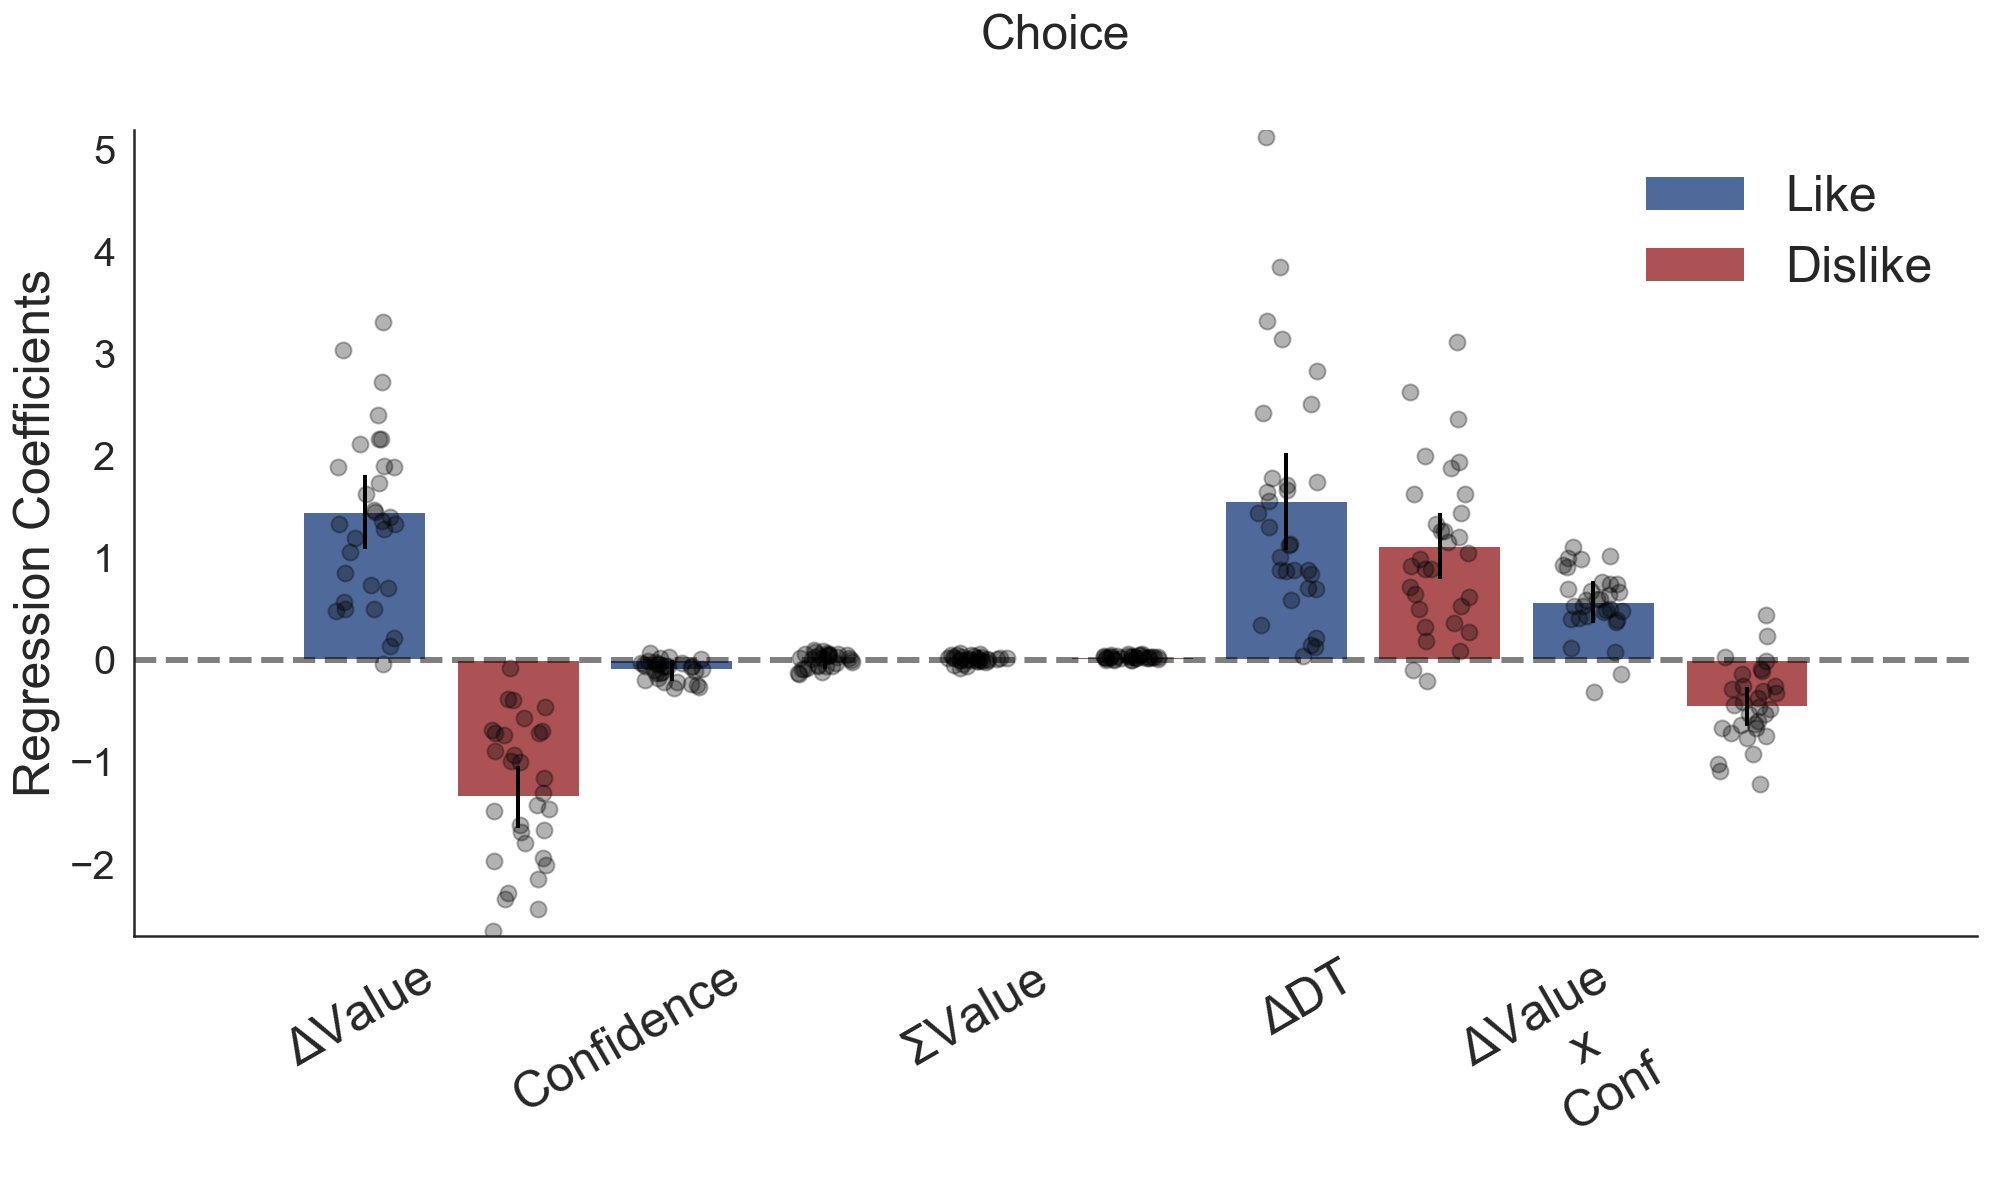

In [26]:
Coefpresplot_bar2(Choice_Like_hmodel_table, mix_Choice_Like_model,Choice_Dislike_hmodel_table, mix_Choice_Dislike_model, barcol1='#4F6A9A',barcol2='#AC5255', title='Choice', size='big',ymultiple=1, ticklabsize=20)
plt.xlim(0, 6)
#plt.savefig('SavedFigures/FF2018ChoiceRegressionLikeDislike_31.svg', format='svg', dpi = 500 )
plt.savefig('SavedFigures/FF2018ChoiceRegressionLikeDislike_31.png', dpi = 500 )

ttestprint (Choice_Like_hmodel_table,Choice_Like_hmodel_table, mix_Choice_Like_model,mix_Choice_Dislike_model )

## Confidence ~ BehavioralParams + GSF

### Dislike condition model

In [27]:
%%R
# Fit the multilevel linear model


if (file.exists('SavedModels/HModel_Confidence_Dislike_31_m1.rda')){
    load('SavedModels/HModel_Confidence_Dislike_31_m1.rda')   
    print('  Found old parameter estimates in "SavedModels/estimates". Skipping estimation...')
}
else{
    confidence_Dislike_hmodel <- lmer(zConf ~  zAbsDVal +zRT +  zTotVal + zGSF + ( zAbsDVal + zRT  + zTotVal + zGSF| Part), data=data_exp1_DisLike, control=lmerControl(optimizer="optimx", optCtrl=list(method="nlminb")))
    save(confidence_Dislike_hmodel, file = "SavedModels/HModel_Confidence_Dislike_31_m1.rda")
    display (confidence_Dislike_hmodel)
}



[1] "  Found old parameter estimates in \"SavedModels/estimates\". Skipping estimation..."


In [28]:
%%R

# Extract mixed effect paramters
mix_Confidence_Dislike_model <- coef(confidence_Dislike_hmodel)

## Estimating DFs and p-values
# get the coefficients for the best fitting model
coefs <- data.frame(coef(summary(confidence_Dislike_hmodel)))
coefs
# Use the Kenward-Roger approximation to get approximate degrees of freedom
df.KR <- get_ddf_Lb(confidence_Dislike_hmodel, fixef(confidence_Dislike_hmodel))
coefs$df.KR <-(rep(df.KR, each=4))

# Calculate confidence intervals from the estimates and the standard errors
coefs$semax <- coefs$Estimate + (coefs$Std..Error)
coefs$semin <- coefs$Estimate - (coefs$Std..Error)

# get p-values from the t-distribution using the t-values and approximated
# degrees of freedom
coefs$p.KR <- 2 * (1 - pt(abs(coefs$t.value), df.KR))

# use normal distribution to approximate p-value (tends to be anti-conservative with small sample sizes)
coefs$p.z <- 2 * (1 - pnorm(abs(coefs$t.value)))


Error in get_ddf_Lb(confidence_Dislike_hmodel, fixef(confidence_Dislike_hmodel)) : 
  could not find function "get_ddf_Lb"


In [29]:
%%R
summary(confidence_Dislike_hmodel)

Linear mixed model fit by REML ['lmerMod']
Formula: zConf ~ zAbsDVal + zRT + zTotVal + zGSF + (zAbsDVal + zRT + zTotVal +  
    zGSF | Part)
   Data: data_exp1_DisLike
Control: lmerControl(optimizer = "optimx", optCtrl = list(method = "nlminb"))

REML criterion at convergence: 9990

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-6.1760 -0.5277  0.2231  0.6800  2.8443 

Random effects:
 Groups   Name        Variance Std.Dev. Corr                   
 Part     (Intercept) 0.009199 0.09591                         
          zAbsDVal    0.011912 0.10914  -0.15                  
          zRT         0.021571 0.14687   0.02 -0.57            
          zTotVal     0.023768 0.15417   0.74 -0.38 -0.33      
          zGSF        0.014813 0.12171   0.06 -0.33  0.11  0.19
 Residual             0.819387 0.90520                         
Number of obs: 3720, groups:  Part, 31

Fixed effects:
            Estimate Std. Error t value
(Intercept) -0.07399    0.02285  -3.238
zAbsDVal     0.

In [30]:
#%%R 
#coef(confidence_Dislike_hmodel)

In [31]:
%%R
z_values =coefs[1]/coefs[2]
z_values

             Estimate
(Intercept) -3.238089
zAbsDVal     6.300381
zRT         -7.739397
zTotVal     -4.492636
zGSF        -2.589255


In [32]:
%R -o coefs -o mix_Confidence_Dislike_model
# extract
mix_Confidence_Dislike_model = mix_Confidence_Dislike_model[0]

conf_table_exp1 = coefs
conf_table_exp1

,Estimate,Std..Error,t.value
0,-0.073989,0.022850,-3.238089
1,0.159536,0.025322,6.300381
2,-0.255417,0.033002,-7.739397
3,-0.143511,0.031944,-4.492636
4,-0.075248,0.029061,-2.589255


In [33]:
mix_Confidence_Dislike_model

(Intercept),zAbsDVal,zRT,zTotVal,zGSF
-0.108069,0.171538,-0.299041,-0.156665,-0.142662
-0.027861,0.168577,-0.238368,-0.118190,-0.013497
-0.000038,0.216838,-0.441125,0.021673,0.064027
-0.033976,0.244614,-0.364445,-0.102106,-0.150714
...,...,...,...,...
-0.024544,0.117465,-0.066499,-0.198487,-0.045629
-0.069684,0.082775,-0.173460,-0.125971,-0.006207
-0.156437,-0.032222,-0.112720,-0.147589,0.048935
0.004763,-0.046368,0.039288,-0.085669,-0.033688


In [34]:
#conf_table_exp1 = conf_table_exp1.T
conf_table_exp1

,Estimate,Std..Error,t.value
0,-0.073989,0.022850,-3.238089
1,0.159536,0.025322,6.300381
2,-0.255417,0.033002,-7.739397
3,-0.143511,0.031944,-4.492636
4,-0.075248,0.029061,-2.589255


In [35]:
#Generate table with paramters to later plot
conf_table_exp1.columns = ['coefficient', 'se', 't' ]
conf_table_exp1 = conf_table_exp1.iloc[:, 0:-1].copy(); conf_table_exp1.loc[:, 'SEmax'] = conf_table_exp1['coefficient'] + conf_table_exp1['se']*2
conf_table_exp1.loc[:, 'SEmin'] = conf_table_exp1['coefficient'] - conf_table_exp1['se']*2
conf_table_exp1 = conf_table_exp1.transpose()


In [36]:
conf_table_exp1.columns = [ 'Inter','|ΔValue|', 'RT', 'ΣValue','GSF']
#conf_table_exp1.loc['p'] = np.round(conf_table_exp1.loc['p'], 4)
conf_table_exp1 = conf_table_exp1[['Inter','|ΔValue|', 'RT', 'ΣValue','GSF']]
conf_table_Dislike = conf_table_exp1

conf_table_Dislike

,Inter,|ΔValue|,RT,ΣValue,GSF
coefficient,-0.073989,0.159536,-0.255417,-0.143511,-0.075248
se,0.022850,0.025322,0.033002,0.031944,0.029061
SEmax,-0.028290,0.210180,-0.189413,-0.079624,-0.017125
SEmin,-0.119688,0.108893,-0.321421,-0.207398,-0.133371


### Like Condition

In [37]:
%%R
# Fit the multilevel linear model
if (file.exists('SavedModels/HModel_Confidence_Like_31_m1.rda')){
    print('  Found old parameter estimates in "SavedModels". Skipping estimation...')
    load('SavedModels/HModel_Confidence_Like_31_m1.rda')   
}
else{
confidence_Like_hmodel <- lmer(zConf ~  zAbsDVal +zRT +  zTotVal + zGSF + ( zAbsDVal + zRT  + zTotVal + zGSF| Part), data=data_exp1_Like, control=lmerControl(optimizer="optimx", optCtrl=list(method="nlminb")))
display (confidence_Like_hmodel)
save(confidence_Like_hmodel, file = "SavedModels/HModel_Confidence_Like_31_m1.rda")
}

[1] "  Found old parameter estimates in \"SavedModels\". Skipping estimation..."


In [38]:
%%R

# Extract mixed effect paramters
mix_Confidence_Like_model <- coef(confidence_Like_hmodel)

## Estimating DFs and p-values
# get the coefficients for the best fitting model
coefs <- data.frame(coef(summary(confidence_Like_hmodel)))
coefs
# Use the Kenward-Roger approximation to get approximate degrees of freedom
df.KR <- get_ddf_Lb(confidence_Like_hmodel, fixef(confidence_Like_hmodel))
coefs$df.KR <-(rep(df.KR, each=4))

# Calculate confidence intervals from the estimates and the standard errors
coefs$semax <- coefs$Estimate + (coefs$Std..Error)
coefs$semin <- coefs$Estimate - (coefs$Std..Error)

# get p-values from the t-distribution using the t-values and approximated
# degrees of freedom
coefs$p.KR <- 2 * (1 - pt(abs(coefs$t.value), df.KR))

# use normal distribution to approximate p-value (tends to be anti-conservative with small sample sizes)
coefs$p.z <- 2 * (1 - pnorm(abs(coefs$t.value)))


Error in get_ddf_Lb(confidence_Like_hmodel, fixef(confidence_Like_hmodel)) : 
  could not find function "get_ddf_Lb"


In [39]:
%%R
summary(confidence_Like_hmodel)

Linear mixed model fit by REML ['lmerMod']
Formula: zConf ~ zAbsDVal + zRT + zTotVal + zGSF + (zAbsDVal + zRT + zTotVal +  
    zGSF | Part)
   Data: data_exp1_Like
Control: lmerControl(optimizer = "optimx", optCtrl = list(method = "nlminb"))

REML criterion at convergence: 9516.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-7.1447 -0.4234  0.2267  0.6512  2.7634 

Random effects:
 Groups   Name        Variance Std.Dev. Corr                   
 Part     (Intercept) 0.012348 0.11112                         
          zAbsDVal    0.009258 0.09622   0.25                  
          zRT         0.039060 0.19764   0.54  0.09            
          zTotVal     0.019230 0.13867  -0.81  0.20 -0.10      
          zGSF        0.008796 0.09379  -0.18 -0.45  0.09  0.10
 Residual             0.719957 0.84850                         
Number of obs: 3720, groups:  Part, 31

Fixed effects:
            Estimate Std. Error t value
(Intercept)  0.05748    0.02455   2.342
zAbsDVal     0.1

In [40]:
%%R
coefs

               Estimate Std..Error   t.value
(Intercept)  0.05748420 0.02454766  2.341738
zAbsDVal     0.12450842 0.02278491  5.464512
zRT         -0.26339985 0.04132764 -6.373454
zTotVal      0.09274652 0.02892570  3.206371
zGSF        -0.06096510 0.02577437 -2.365338


In [41]:
%%R

z_values =coefs[1]/coefs[2]
z_values

             Estimate
(Intercept)  2.341738
zAbsDVal     5.464512
zRT         -6.373454
zTotVal      3.206371
zGSF        -2.365338


In [42]:
%R -o coefs -o mix_Confidence_Like_model

mix_Confidence_Like_model = mix_Confidence_Like_model[0]

conf_table_exp1 = coefs
conf_table_exp1

,Estimate,Std..Error,t.value
0,0.057484,0.024548,2.341738
1,0.124508,0.022785,5.464512
2,-0.263400,0.041328,-6.373454
3,0.092747,0.028926,3.206371
4,-0.060965,0.025774,-2.365338


In [43]:
conf_table_exp1

,Estimate,Std..Error,t.value
0,0.057484,0.024548,2.341738
1,0.124508,0.022785,5.464512
2,-0.263400,0.041328,-6.373454
3,0.092747,0.028926,3.206371
4,-0.060965,0.025774,-2.365338


In [44]:
#Generate table with paramters to later plot
conf_table_exp1.columns = ['coefficient', 'se', 't' ]
conf_table_exp1 = conf_table_exp1.iloc[:, 0:-1].copy(); conf_table_exp1.loc[:, 'SEmax'] = conf_table_exp1['coefficient'] + conf_table_exp1['se']*2
conf_table_exp1.loc[:, 'SEmin'] = conf_table_exp1['coefficient'] - conf_table_exp1['se']*2
conf_table_exp1 = conf_table_exp1.transpose()


In [45]:
conf_table_exp1.columns = [ "Inter",'|ΔValue|', 'RT', 'ΣValue','GSF']
#conf_table_exp1.loc['p'] = np.round(conf_table_exp1.loc['p'], 4)
conf_table_exp1 = conf_table_exp1[["Inter",'|ΔValue|','RT', 'ΣValue','GSF']]
conf_table_Like = conf_table_exp1
conf_table_Like

,Inter,|ΔValue|,RT,ΣValue,GSF
coefficient,0.057484,0.124508,-0.263400,0.092747,-0.060965
se,0.024548,0.022785,0.041328,0.028926,0.025774
SEmax,0.106580,0.170078,-0.180745,0.150598,-0.009416
SEmin,0.008389,0.078939,-0.346055,0.034895,-0.112514


### Plotting both conditions

Mismatch
---------------- SIGNIFICANT FACTOR ----------------------
Inter : MeanL = 0.06; t =  3.23 ; p-value =0.0**
Inter : MeanD = -0.07; t =  -5.14725 ; p-value =2e-05***
|ΔValue| : MeanL = 0.12; t =  8.90148 ; p-value =0.0***
|ΔValue| : MeanD = 0.16; t =  9.61012 ; p-value =0.0***
RT : MeanL = -0.26; t =  -8.3196 ; p-value =0.0***
RT : MeanD = -0.26; t =  -11.09739 ; p-value =0.0***
ΣValue : MeanL = 0.09; t =  4.12488 ; p-value =0.00027***
ΣValue : MeanD = -0.14; t =  -5.85096 ; p-value =0.0***
GSF : MeanL = -0.06; t =  -4.93787 ; p-value =3e-05***
GSF : MeanD = -0.08; t =  -4.29397 ; p-value =0.00017***
---------------- COMPARE [ LIKE - DISLIKE ] ----------------------
Inter : MeanL = 0.06; MeanD = -0.07399; [Like - Dislike] =  0.0; t =  4.34953 ; p-value =0.00014***
|ΔValue| : MeanL = 0.12; MeanD = 0.16; [Like - Dislike] =  -0.0; t =  -3.129 ; p-value =0.004**
RT : MeanL = -0.26; MeanD = -0.26; [Like - Dislike] =  -0.0; t =  -0.232 ; p-value =0.818
ΣValue : MeanL = 0.09; MeanD = 

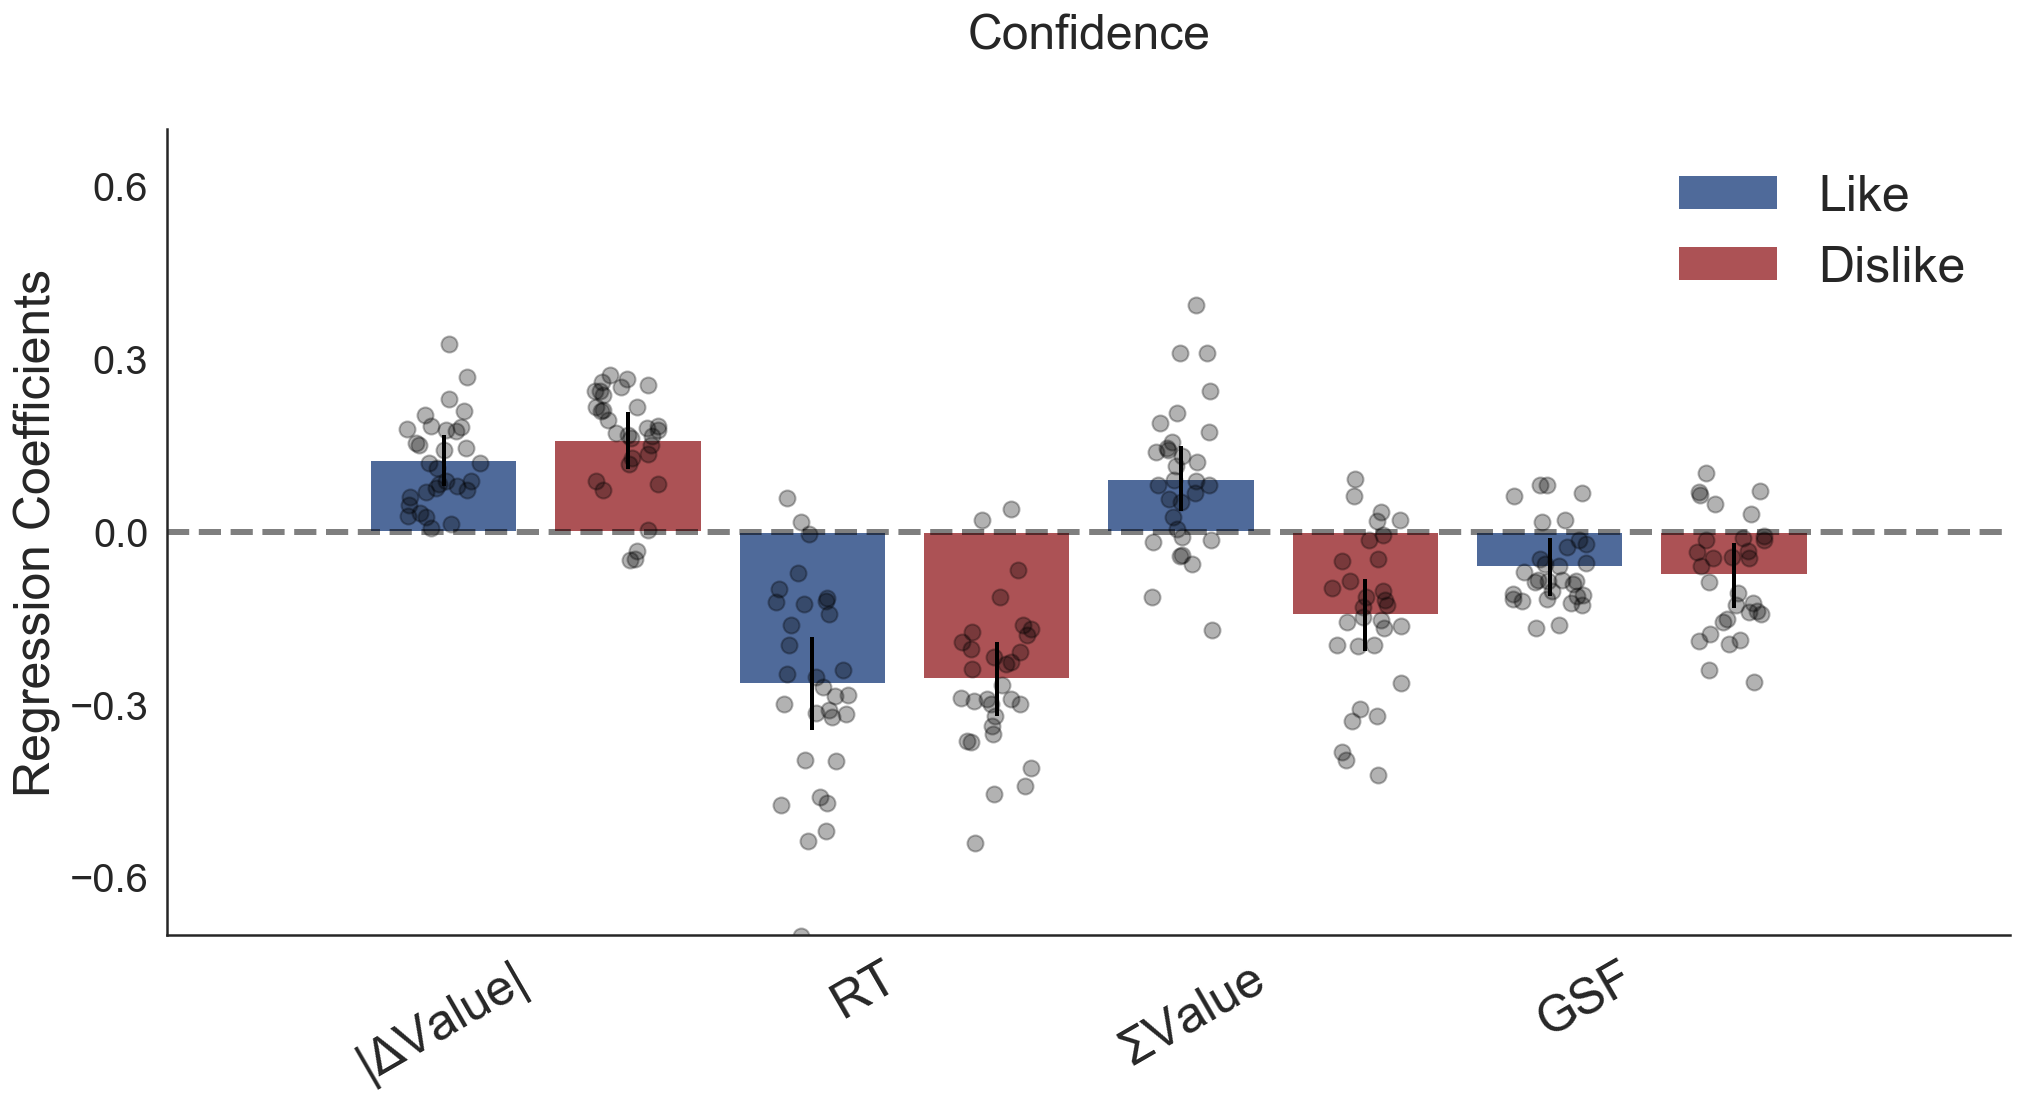

In [46]:
Coefpresplot_bar2(conf_table_Like, mix_Confidence_Like_model,conf_table_Dislike, mix_Confidence_Dislike_model, barcol1='#4F6A9A',barcol2='#AC5255', title='Confidence', size='big',ymultiple=0.3, ticklabsize=20)
plt.xlim(0, 5)

ttestprint (conf_table_Like,conf_table_Dislike, mix_Confidence_Like_model,mix_Confidence_Dislike_model )

plt.savefig(str('SavedFigures/FF2018ConfidenceRegressionLikeDislike_31.png'), dpi = 200 )


# Are DDT params correlated within participants?

In [47]:
mix_Choice_Like_model

(Intercept),zDVal,zConf,zTotVal,zDDT,zDVal:zConf
0.155879,2.731246,-0.207852,0.054793,1.789168,0.994016
0.087170,2.167497,-0.125810,0.053753,0.880589,1.001364
-0.026003,2.170695,-0.018493,0.053983,0.130670,0.931204
0.016470,2.118750,-0.057253,0.015063,1.651901,0.482929
...,...,...,...,...,...
-0.053518,1.399518,0.030645,0.021604,0.348950,0.600972
0.137571,0.506871,-0.124065,-0.005367,1.721997,0.491783
0.129280,0.221593,-0.107679,-0.057768,3.151694,-0.129231
-0.072400,0.572458,0.073259,0.000113,0.215468,0.417335


In [127]:
mix_Choice_Dislike_model

(Intercept),zDVal,zConf,zTotVal,zDDT,zDVal:zConf
-0.013959,-2.335181,0.012639,-0.000144,0.622518,-0.662075
-0.051703,-1.935839,0.051948,0.040555,0.091693,-1.213378
-0.057276,-2.435479,0.003766,0.007646,-0.204904,-1.088590
0.010287,-1.611461,-0.058353,0.002384,0.717703,-0.316707
...,...,...,...,...,...
0.011801,-1.417967,0.059274,0.043260,1.263740,-0.620626
-0.006905,-0.984292,-0.080384,0.028541,0.278506,-0.523659
0.042934,-0.706958,0.020776,0.052101,1.630800,-0.281948
-0.000489,-0.888479,-0.085126,0.029113,0.370558,-0.455485


# Pearson corr coef for DDT param

In [128]:
np.corrcoef(mix_Choice_Like_model[4],mix_Choice_Dislike_model[4])

array([[1.        , 0.58138684],
       [0.58138684, 1.        ]])

In [129]:
plt.scatter(x, y)
plt.show()

NameError: name 'x' is not defined